<a href="https://colab.research.google.com/github/taggartpatrick/basic_bike_sales_analytics/blob/main/Bike_Sales_Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load libraries


In [1]:
# Load basic libraries
import pandas as pd
import numpy as np
import altair as alt
import datetime as dt

In [2]:
# load interactive tables
%load_ext google.colab.data_table

In [3]:
# load plotly 
!pip install -q plotly==4.2.1
import plotly.graph_objects as go

from IPython.display import HTML
import plotly.express as px

     |████████████████████████████████| 7.2MB 3.9MB/s 


In [4]:
# load seaborn libraries 
import seaborn as sns
import matplotlib.pyplot as plt 

### Import data


#### Import data from Gitbuh repo

In [5]:
# Clone Github directory
!git clone https://github.com/taggartpatrick/basic_bike_sales_analytics
!ls

Cloning into 'basic_bike_sales_analytics'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.
basic_bike_sales_analytics  sample_data


In [6]:
# Import ordeline data 
orderlines = pd.read_excel("/content/basic_bike_sales_analytics/orderlines.xlsx")

# Import bikeshop data 
bikeshops = pd.read_excel("/content/basic_bike_sales_analytics/bikeshops.xlsx")

# Import bike data 
bikes = pd.read_excel("/content/basic_bike_sales_analytics/bikes.xlsx")

In [7]:
# Import bike orderline data 
bike_orderlines = pd.read_csv("/content/basic_bike_sales_analytics/bike_orderlines.csv")

### Tidy and Transform Bike Sales Data

#### Combine Excel Files into one dataframe

In [10]:
# Rename key fields in relevant excel based dataframes for merging

bikes = bikes.rename(columns = {'bike.id':'product.id'})
bikeshops = bikeshops.rename(columns = {'bikeshop.id': 'customer.id'})

# Join dataframes into one overall dataframe

bike_order_data = pd.merge(orderlines,bikes, on = 'product.id')
bike_order_data = pd.merge(bike_order_data,bikeshops, on = 'customer.id')

#### Tidy Dataframe

In [11]:
# Rename key fields
bike_sales_tbl = bike_order_data.rename(columns = {
    'order.date' : 'order_date',
    'order.id' : 'order_id',
    'order.line' : 'order_line',
    'bikeshop.name':'bikeshop_name'
    })

# Drop uneeded fields 
bike_sales_tbl = bike_sales_tbl.drop(['Unnamed: 0','customer.id','product.id'], axis = 1) 

# Split location fields and split decsription fields 
bike_sales_tbl[['major_category','minor_category','frame_material']] = bike_sales_tbl['description'].str.split(' - ',2,expand = True)

# Add fields for month, day and year

def get_ym(x): return dt.datetime(x.year,x.month,1)

bike_sales_tbl['order_month'] = pd.DatetimeIndex(bike_sales_tbl['order_date']).month
bike_sales_tbl['order_day'] = pd.DatetimeIndex(bike_sales_tbl['order_date']).day
bike_sales_tbl['order_year'] = pd.DatetimeIndex(bike_sales_tbl['order_date']).year
bike_sales_tbl['order_ym'] = bike_sales_tbl['order_date'].apply(get_ym)
bike_sales_tbl['order_weekday'] = pd.to_datetime(bike_sales_tbl['order_date']).dt.day_name()

# Add total sales value 
bike_sales_tbl['sales_value'] = bike_sales_tbl['price']*bike_sales_tbl['quantity']


### Perform Basic customer segment analysis

#### Analyse customer cohorts

Customer cohort anlaysis looks at two things: 
1. When a customer made their first purchase 
2. How many months a customer was active after that first purchase

If individual customer purchase trends are aggregated, you can easily get a view of the number of active customers monthly relative to when they made their first purchase 

If this number remains high it means customers are loyal 


Step 1: Get Cohort count matrix

In [14]:
# Filter sales table to see data for a specific year 

filter_years = ['2012']

cust_sales_tbl = bike_sales_tbl[bike_sales_tbl['order_year'].isin(filter_years)]

In [15]:
# Get date of first purchase month by customer 
grouping = cust_sales_tbl.groupby(['bikeshop_name'])['order_ym']
cust_sales_tbl['cohort_ym'] = grouping.transform('min')

# Get Month's offset from initial purchase 
def get_date_int (df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

order_year,order_month,_ = get_date_int(cust_sales_tbl,'order_ym')
cohort_year,cohort_month,_ = get_date_int(cust_sales_tbl,'cohort_ym')
years_diff = order_year - cohort_year
months_diff = order_month - cohort_month

cust_sales_tbl['cohort_index'] = years_diff*12 + months_diff + 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
cust_sales_tbl.head()

,order_id,order_line,order_date,quantity,model,description,price,bikeshop_name,location,major_category,minor_category,frame_material,order_month,order_day,order_year,order_ym,order_weekday,sales_value,cohort_ym,cohort_index
2,507,2,2012-06-26,1,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,6,26,2012,2012-06-01,Tuesday,6070,2012-03-01,4
3,528,18,2012-07-16,1,Jekyll Carbon 2,Mountain - Over Mountain - Carbon,6070,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,7,16,2012,2012-07-01,Monday,6070,2012-03-01,5
21,460,2,2012-05-08,1,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,5,8,2012,2012-05-01,Tuesday,5970,2012-03-01,3
22,479,5,2012-06-06,1,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,6,6,2012,2012-06-01,Wednesday,5970,2012-03-01,4
23,507,9,2012-06-26,1,Trigger Carbon 2,Mountain - Over Mountain - Carbon,5970,Ithaca Mountain Climbers,"Ithaca, NY",Mountain,Over Mountain,Carbon,6,26,2012,2012-06-01,Tuesday,5970,2012-03-01,4


In [17]:
# Count No of monthly active customers from each cohort 

grouping = cust_sales_tbl.groupby(['cohort_ym','cohort_index'])
cohort_data = grouping['bikeshop_name'].apply(pd.Series.nunique).reset_index()
cohort_counts = cohort_data.pivot(index = 'cohort_ym',columns = 'cohort_index',values = 'bikeshop_name')

print(cohort_counts)

cohort_index    1    2    3    4    5    6    7    8    9    10   11   12
cohort_ym                                                                
2012-01-01    11.0  8.0  8.0  9.0  5.0  8.0  8.0  5.0  6.0  7.0  8.0  8.0
2012-02-01     9.0  6.0  7.0  4.0  2.0  3.0  6.0  3.0  4.0  3.0  1.0  NaN
2012-03-01     7.0  4.0  2.0  3.0  2.0  4.0  4.0  2.0  3.0  1.0  NaN  NaN
2012-06-01     2.0  2.0  1.0  1.0  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2012-07-01     1.0  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN


Step 2: Calculate cohort metrics

Calculate retention rate (%)

In [18]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis = 0).round(3)
retention = retention.reset_index()
retention

cohort_index,cohort_ym,1,2,3,4,5,6,7,8,9,10,11,12
0,2012-01-01,1.0,0.727,0.727,0.818,0.455,0.727,0.727,0.455,0.545,0.636,0.727,0.727
1,2012-02-01,1.0,0.667,0.778,0.444,0.222,0.333,0.667,0.333,0.444,0.333,0.111,NaN
2,2012-03-01,1.0,0.571,0.286,0.429,0.286,0.571,0.571,0.286,0.429,0.143,NaN,NaN
3,2012-06-01,1.0,1.000,0.500,0.500,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-07-01,1.0,NaN,NaN,NaN,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Show heatmap active customer matrix


In [19]:
base = alt.Chart(cohort_data).encode(
    alt.X('cohort_index:O', scale=alt.Scale(paddingInner=0)),
    alt.Y('cohort_ym:O', scale=alt.Scale(paddingInner=0)),
).properties(width=600, height=200)

heatmap = base.mark_rect().encode(
    color = alt.Color('bikeshop_name',scale=alt.Scale(scheme='blues'))
)
text = base.mark_text(baseline = 'middle').encode(
    text = 'bikeshop_name:Q',
    color = alt.condition(
        alt.datum.bikeshop_name > 7,
        alt.value('white'),
        alt.value('black')
        )
)
    
heatmap + text

alt.LayerChart(...)

Show heatmap customer retention rate (%) matrix

In [20]:
# Convert retention matrix from wide to long
retention_data = pd.melt(retention, id_vars = ['cohort_ym'],value_name = 'retention_pct')
retention_data.head(25)

,cohort_ym,cohort_index,retention_pct
0,2012-01-01,1,1.000
1,2012-02-01,1,1.000
2,2012-03-01,1,1.000
3,2012-06-01,1,1.000
4,2012-07-01,1,1.000
5,2012-01-01,2,0.727
6,2012-02-01,2,0.667
7,2012-03-01,2,0.571
8,2012-06-01,2,1.000
9,2012-07-01,2,NaN


In [21]:
base = alt.Chart(retention_data).encode(
    alt.X('cohort_index:O', scale=alt.Scale(paddingInner=0)),
    alt.Y('cohort_ym:O', scale=alt.Scale(paddingInner=0)),
).properties(width=600, height=200)

heatmap = base.mark_rect().encode(
    color = alt.Color('retention_pct',scale=alt.Scale(scheme='blues'))
)
text = base.mark_text(baseline = 'middle').encode(
    text = 'retention_pct',
    color = alt.condition(
        alt.datum.retention_pct > 0.7,
        alt.value('white'),
        alt.value('black')
        )
)
heatmap + text

alt.LayerChart(...)

Calculate average sales value for each cohort

In [22]:
cohort_sales_tbl = cust_sales_tbl.groupby(['cohort_ym','cohort_index'])['sales_value'].sum().reset_index()

cohort_sales_matrix = cohort_sales_tbl.pivot(index = 'cohort_ym',columns = 'cohort_index', values = 'sales_value')

cohort_sales_matrix.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_ym,,,,,,,,,,,,
2012-01-01,710800.0,500865.0,1015265.0,785425.0,576180.0,623790.0,726525.0,567335.0,396150.0,345185.0,606570.0,549835.0
2012-02-01,170925.0,306330.0,299900.0,282190.0,185120.0,83890.0,477360.0,94150.0,176310.0,87945.0,8250.0,NaN
2012-03-01,183470.0,534900.0,103810.0,181390.0,350805.0,216585.0,461610.0,17790.0,22030.0,3940.0,NaN,NaN
2012-06-01,39610.0,261875.0,28770.0,124100.0,3500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-01,49455.0,NaN,NaN,NaN,3140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Create cohort retention rate heatmap

In [23]:
cohort_data

,cohort_ym,cohort_index,bikeshop_name
0,2012-01-01,1,11
1,2012-01-01,2,8
2,2012-01-01,3,8
3,2012-01-01,4,9
4,2012-01-01,5,5
5,2012-01-01,6,8
6,2012-01-01,7,8
7,2012-01-01,8,5
8,2012-01-01,9,6
9,2012-01-01,10,7


#### Analyse customer RFM (Recency, Frequency, Monetary Value)

Create basic RFM Table

In [24]:
# Create a table that shows, by customer their: Name, Days since last purchase (Recency), No fo purcahses (frequency) and total sales value (total_sales)

# Get latest date
snapshot_date = max(cust_sales_tbl['order_date']) + dt.timedelta(days=1)

# Create a customer RFM matrix 

customer_RFM_tbl= cust_sales_tbl.groupby(['bikeshop_name']).agg({
    'order_date' : lambda x: (snapshot_date - x.max()).days,
    'order_line' : 'count',
    'sales_value' : 'sum'})

customer_RFM_tbl.rename( columns = {'order_date' : 'recency',
                                    'order_line' : 'frequency',
                                    'sales_value' : 'total_sales'}, inplace = True)
customer_RFM_tbl.head()

,recency,frequency,total_sales
bikeshop_name,,,
Albuquerque Cycles,294,16,81035
Ann Arbor Speed,41,100,565625
Austin Cruisers,36,47,215310
Cincinnati Speed,124,44,272440
Columbus Race Equipment,103,61,324300


Create RFM segments 

In [25]:
# Create quartiles to group RFM values into bins. 
# Generate labels for recency and asisgn to new column: R 
r_labels = range(4,0,-1)
r_quartiles = pd.qcut(customer_RFM_tbl['recency'],4,labels = r_labels)
customer_RFM__segment_tbl = customer_RFM_tbl.assign(R = r_quartiles.values)

# Generate labels for frequency and asisgn to new column: F 
f_labels = range(1,5)
f_quartiles = pd.qcut(customer_RFM_tbl['frequency'],4,labels = f_labels)
customer_RFM__segment_tbl = customer_RFM__segment_tbl.assign(F = f_quartiles.values)

# Generate labels for frequency and asisgn to new column: M 
m_labels = range(1,5)
m_quartiles = pd.qcut(customer_RFM_tbl['total_sales'],4,labels = m_labels)
customer_RFM__segment_tbl = customer_RFM__segment_tbl.assign(M = m_quartiles.values)

#Create RFM Segments 
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

customer_RFM__segment_tbl['RFM_segment'] = customer_RFM__segment_tbl.apply(join_rfm, axis =1)
customer_RFM__segment_tbl['RFM_Score'] = customer_RFM__segment_tbl[['R','F','M']].sum(axis=1)

Review RFM Segment statistics

In [26]:
customer_RFM__segment_tbl.groupby('RFM_Score').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'total_sales' : ['mean','count']}).round(1)

recency frequency total_sales      
             mean      mean        mean count
RFM_Score                                    
3           204.5      14.0     82072.5     4
4            79.3      32.7    146673.3     3
5            89.8      35.8    156263.8     4
6           124.0      44.0    272440.0     1
7            36.0      47.0    215310.0     1
8            49.8      59.2    281285.8     6
9            25.0      98.0    388100.0     1
10           34.7      88.7    455866.7     3
11           33.7     127.7    547385.0     3
12           16.8     291.2   1299097.5     4

Group RFM scores into named segments

In [27]:
def segment_me(df) : 
    if df['RFM_Score'] >= 9: 
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else: 
        return 'Bronze'

customer_RFM__segment_tbl['general_segment'] = customer_RFM__segment_tbl.apply(segment_me,axis =1)

customer_RFM__segment_tbl.groupby('general_segment').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'total_sales' : ['mean','count']}).round(1)

recency frequency total_sales      
                   mean      mean        mean count
general_segment                                    
Bronze            150.9      22.0    109758.6     7
Gold               27.0     173.8    781295.0    11
Silver             68.2      49.1    233376.7    12

In [28]:
customer_RFM__segment_tbl.head()

,recency,frequency,total_sales,R,F,M,RFM_segment,RFM_Score,general_segment
bikeshop_name,,,,,,,,,
Albuquerque Cycles,294,16,81035,1,1,1,111,3,Bronze
Ann Arbor Speed,41,100,565625,3,3,4,334,10,Gold
Austin Cruisers,36,47,215310,3,2,2,322,7,Silver
Cincinnati Speed,124,44,272440,1,2,3,123,6,Silver
Columbus Race Equipment,103,61,324300,2,3,3,233,8,Silver


### Perform Advanced custmer segment analysis (K means clustering)

#### Prepare data for k means clustering

Prepare data for k means.  Data must be: 
- Normally distributed 
- Normalized (same scale for mean and standard deviation) 


First look at recency & frequency data skewness as is

In [ ]:
customer_RFM_tbl.head()

,recency,frequency,total_sales
bikeshop_name,,,
Albuquerque Cycles,294,16,81035
Ann Arbor Speed,41,100,565625
Austin Cruisers,36,47,215310
Cincinnati Speed,124,44,272440
Columbus Race Equipment,103,61,324300


In [ ]:
chart_1 = alt.Chart(customer_RFM_tbl).mark_bar().encode(
    alt.X('frequency:Q', bin = alt.Bin(maxbins=25)),
    y = 'count()',
)

chart_2 = alt.Chart(customer_RFM_tbl).mark_bar().encode(
    alt.X('recency:Q', bin = alt.Bin(maxbins=25)),
    y = 'count()',
)

chart_3 = alt.Chart(customer_RFM_tbl).mark_bar().encode(
    alt.X('total_sales:Q', bin = alt.Bin(maxbins=25)),
    y = 'count()',
)

chart_1 | chart_2 | chart_3

alt.HConcatChart(...)

Normalize the data for clustering. This involves: 


*   Unskewing the data (via log transformations)
*   Centering & scaling the data (aka 'Normalizing' the data) 

In [ ]:
# Apply unskewing operations to data and save as separate dataframe
customer_RFM_log_tbl =  np.log(customer_RFM_tbl)

# Normalize the variables (x - x.mean to get centered and x / s.std() to get scaled data). Both can be done with scikit-learn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(customer_RFM_log_tbl)

#Store for clustring 
customer_RFM_normalized = scaler.transform(customer_RFM_log_tbl)

# Create clustering ready dataframe
customer_RFM_normalized = pd.DataFrame(customer_RFM_normalized, index = customer_RFM_tbl.index, columns = customer_RFM_tbl.columns)


#### Apply K means clustering

In [ ]:
# import key libraries
from sklearn.cluster import KMeans

Choose the correct number of clusters using ('elbow' method)

In [ ]:
# Create empty array
sse = {}

# Loop clustering algorithm over k to get sse values for every value of k 
for k in range (1,11):
    kmeans = KMeans(n_clusters = k, random_state=1)
    kmeans.fit(customer_RFM_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Plot SSE for every K
source = pd.DataFrame({'sse':sse}).reset_index().rename(columns = {'index' : 'k'})

alt.Chart(source).mark_line().encode(
    x='k',
    y='sse',
    tooltip = ['k','sse']
)

alt.Chart(...)

In [ ]:
# From above chart 3 or 4 clusters looks reasonable 

# for selected clusters apply clusting on kmeans cluster to get cluster labels
kmeans = KMeans(n_clusters=3,random_state=1)
kmeans.fit(customer_RFM_normalized)
cluster_labels = kmeans.labels_

# Assign cluster labels to normal RFM data 
customer_RFM_k_tbl = customer_RFM_tbl.assign(cluster = cluster_labels)

# Assign cluster labels to normalized RFM data 

customer_RFM_k_norm_tbl = customer_RFM_normalized.assign(cluster = cluster_labels)

In [ ]:
customer_RFM_k_norm_tbl.head()

,recency,frequency,total_sales,cluster
bikeshop_name,,,,
Albuquerque Cycles,1.647202,-1.359626,-1.205206,2
Ann Arbor Speed,-0.054279,0.605109,0.783586,1
Austin Cruisers,-0.166605,-0.204361,-0.205004,0
Cincinnati Speed,0.901577,-0.275075,0.035876,0
Columbus Race Equipment,0.741317,0.075167,0.214229,0


#### Profile and Interpret cluster segments

Look at key RFM statistics for each cluster

In [ ]:
# look at key Normalized RFM statistics for selected clusters 

customer_RFM_k_tbl.groupby('cluster').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'total_sales' : ['mean','count']}).round(1)

recency frequency total_sales      
           mean      mean        mean count
cluster                                    
0          90.8      43.9    226694.6    12
1          23.4     147.9    659361.4    14
2         188.2      14.2     52920.0     4

Generate Snake Plot

In [ ]:
# Generate snake plot of segments
customer_RFM_k_melt = pd.melt(customer_RFM_k_norm_tbl.reset_index(),
                              id_vars = ['bikeshop_name','cluster'],
                              value_vars = ['recency','frequency','total_sales'],
                              var_name = 'attribute',
                              value_name = 'value')

source = customer_RFM_k_melt

snake_plot = alt.Chart(source).mark_point().encode(
    x='attribute:O',
    y='value:Q',
    color='cluster:O',
).properties(
    width=250,
    height=250
)

snake_plot

alt.Chart(...)

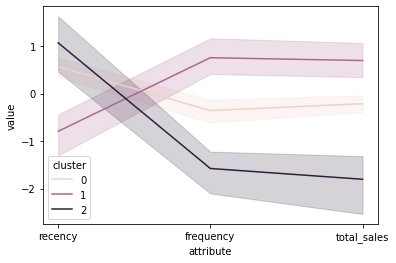

In [ ]:
sns.lineplot(x ='attribute',y = 'value',hue = 'cluster', data = customer_RFM_k_melt)

Generate relative importance matrix

In [ ]:
# Generate relative importance table
cluster_ave = customer_RFM_k_tbl.groupby(['cluster']).mean()
population_ave = customer_RFM_tbl.mean()
relative_imp = cluster_ave/ population_ave - 1

In [ ]:
relative_imp.round(2)

,recency,frequency,total_sales
cluster,,,
0,0.26,-0.50,-0.44
1,-0.68,0.67,0.63
2,1.60,-0.84,-0.87


In [ ]:

source = pd.melt(relative_imp.reset_index(),
                 id_vars = ['cluster'],
                 value_vars = ['recency','frequency','total_sales'],
                 var_name = 'attribute',
                 value_name = 'relative_imp')

base = alt.Chart(source.round(2)).encode(
    alt.X('attribute:O', scale=alt.Scale(paddingInner=0)),
    alt.Y('cluster:O', scale=alt.Scale(paddingInner=0)),
).properties(width=600, height=200)

heatmap = base.mark_rect().encode(
    color = alt.Color('relative_imp',scale=alt.Scale(scheme='blues'))
)
text = base.mark_text(baseline = 'middle').encode(
    text = 'relative_imp:Q',
    color = alt.condition(
        alt.datum.relative_imp > 0,
        alt.value('white'),
        alt.value('black')
        )
)
    
heatmap + text

alt.LayerChart(...)